In [1]:
from graphstats.embed import OmnibusEmbed, AdjacencySpectralEmbed
from graphstats.utils import symmetrize

import numpy as np
from numpy.random import dirichlet, binomial
from numpy.linalg import norm
import matplotlib.pyplot as plt

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

%matplotlib inline

## Experimental Setup

Let $X_1, \ldots, X_n \overset{iid}{\sim} Dirichlet(1, 1, 1) \in \mathbb{R}^3$, and let $X = [X_1, \ldots, X_n]^T$ be the latent position matrix.

Let the probability matrix be $P = XX^T$. We sample two adjacency matrices, $A_1, A_2 \sim Bern(P)$ such that $a_{ij} = Bern(p_{ij})$, and making sure that $A = A^T$.

We compare the estimated latent position, $\hat{X}$, from the following three embeddings:

1. OmniBar - Let $M = \begin{bmatrix}A_1 & \frac{A_1 + A_2}{2}\\ \frac{A_1 + A_2}{2} & A_2\end{bmatrix}$. Let $\hat{X}_{omni} = ASE(M, 3)$, and let $\bar{X}_{omni}$ be the average of first n rows and second n rows of $\hat{X}_{omni}$. 
2. ABar - Let $\bar{A} = \frac{A_1 + A_2}{2}$. We compute $\hat{X}_{ABar} = ASE(\bar{A}, 3)$
3. ASE1 - Let $\hat{X}_{ASE1} = ASE(A_1, 3)$.

Note we embed into $\mathbb{R}^3$. Once the estimates are computed, we compute $MSE = \frac{1}{n}||\hat{X} - X||_F^2$ where $n$ is the number of vertices.

We vary $n \in \{20, 30, 50, 80, 100, 200, 300, 500, 800, 1000\}$.

In [2]:
def compute_mse(X, Xhat):
    n = X.shape[0]
    mse = (norm(X-Xhat)**2) / n
    
    return mse

In [3]:
def run_experiment(seed=1):
    n_vertices = [20, 30, 50, 80, 100, 200, 300, 500, 800, 1000]

    np.random.seed(seed)

    mse_omni = []
    mse_abar = []
    mse_ase1 = []

    for n in n_vertices:
        X = dirichlet([1, 1, 1], size=n)

        P = X @ X.T

        A1 = symmetrize(binomial(1, P))
        A2 = symmetrize(binomial(1, P))

        Abar = (A1 + A2) / 2

        omni = OmnibusEmbed(k=3)
        X_omni = omni.fit_transform([A1, A2])
        X_omnibar = (X_omni[:n] + X_omni[n:]) / 2
        mse_omni.append(compute_mse(X, X_omnibar))

        ase = AdjacencySpectralEmbed(k=3)
        X_abar = ase.fit_transform(Abar)
        mse_abar.append(compute_mse(X, X_abar))

        ase = AdjacencySpectralEmbed(k=3)
        X_ase1 = ase.fit_transform(A1)
        mse_ase1.append(compute_mse(X, X_ase1))
    
    return (mse_omni, mse_abar, mse_ase1)

In [4]:
mse_omni, mse_abar, mse_ase1 = run_experiment()

### Plotting results

In [5]:
def make_plot(mse_omni, mse_abar, mse_ase1):
    n_vertices = [20, 30, 50, 80, 100, 200, 300, 500, 800, 1000]

    fig, ax = plt.subplots(figsize = (10, 6))

    ax.plot(n_vertices, mse_omni, label='OmniBar')
    ax.plot(n_vertices, mse_abar, label='ABar')
    ax.plot(n_vertices, mse_ase1, label='ASE1')
    ax.legend()
    ax.set_ylabel('Mean Squared Error', fontsize=16)
    ax.set_xlabel('Number of vertices', fontsize=16)

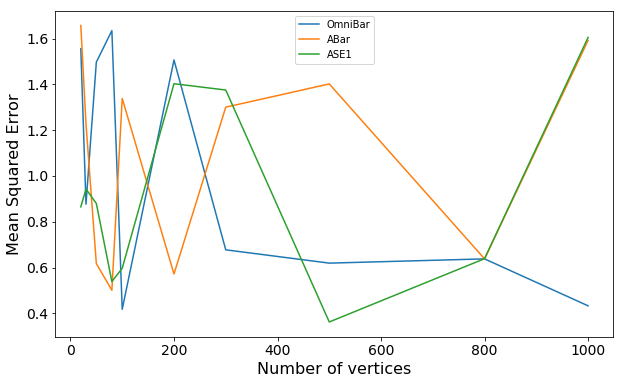

In [6]:
make_plot(mse_omni, mse_abar, mse_ase1)

### Above plot doesn't look right

So now we try:

$MSE = \frac{1}{n}(\sum_{i=1}^n (||x_{i.}|| - ||\hat{x}_{i.}||)^2$)

In [7]:
def compute_mse(X, Xhat):
    n = X.shape[0]
    mse = ((norm(X, axis = 1) - norm(Xhat, axis = 1))**2).mean()
    
    return mse

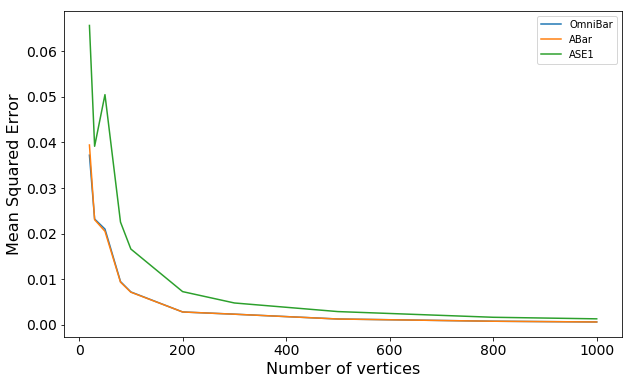

In [8]:
mse_omni, mse_abar, mse_ase1 = run_experiment()
make_plot(mse_omni, mse_abar, mse_ase1)